## Quick validation of network modules

In [1]:
%load_ext autoreload
%autoreload 2
import os
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core_acc_modules import paths

np.random.seed(1)

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Examine size of modules

In [2]:
corr_threshold_list = [0.9, 0.8, 0.7, 0.6, 0.5]

for corr_threshold in corr_threshold_list:
    print(f"Modules using correlation threshold: {corr_threshold}")
    pao1_membership_filename = f"pao1_membership_{corr_threshold}.tsv"
    pa14_membership_filename = f"pa14_membership_{corr_threshold}.tsv"

    pao1_membership = pd.read_csv(
        pao1_membership_filename, sep="\t", header=0, index_col=0
    )
    pa14_membership = pd.read_csv(
        pa14_membership_filename, sep="\t", header=0, index_col=0
    )

    print(pao1_membership["module id"].value_counts())
    print(pa14_membership["module id"].value_counts())

Modules using correlation threshold: 0.9
0.0    4530
1.0     244
2.0     170
3.0     149
4.0     127
5.0     106
6.0      84
7.0      70
8.0      51
9.0      32
Name: module id, dtype: int64
0.0    5192
1.0     391
2.0     120
3.0      81
4.0      37
6.0      35
5.0      35
Name: module id, dtype: int64
Modules using correlation threshold: 0.8
0.0     3165
1.0     1060
2.0      536
3.0      197
4.0      120
5.0       82
6.0       75
7.0       49
8.0       42
9.0       38
10.0      36
11.0      35
12.0      34
13.0      32
14.0      32
15.0      30
Name: module id, dtype: int64
0.0     3600
1.0      828
2.0      191
3.0      116
4.0       82
6.0       80
5.0       80
7.0       72
8.0       66
9.0       65
10.0      62
11.0      59
13.0      46
12.0      46
14.0      44
15.0      44
18.0      42
16.0      42
17.0      42
19.0      40
20.0      38
21.0      37
22.0      36
23.0      36
24.0      34
25.0      32
26.0      31
Name: module id, dtype: int64
Modules using correlation threshold

In [3]:
# plotting function
def plot_dist_modules(threshold_list):

    # Set up the matplotlib figure
    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(len(threshold_list)):
        pao1_membership_filename = f"pao1_membership_{threshold_list[i]}.tsv"
        pa14_membership_filename = f"pa14_membership_{threshold_list[i]}.tsv"

        pao1_membership = pd.read_csv(
            pao1_membership_filename, sep="\t", header=0, index_col=0
        )
        pa14_membership = pd.read_csv(
            pa14_membership_filename, sep="\t", header=0, index_col=0
        )

        # Get bins using all data
        hist, bins_corr = np.histogram(
            np.concatenate([pao1_membership["module id"], pa14_membership["module id"]])
        )

        # Distribution plot for core genes
        fig = sns.distplot(
            pao1_membership["module id"],
            label="PAO1 modules",
            color="red",
            bins=bins_corr,
            kde=False,
            ax=axes[i],
        )

        fig = sns.distplot(
            pa14_membership["module id"],
            label="PA14 modules",
            color="blue",
            bins=bins_corr,
            kde=False,
            ax=axes[i],
        )

        fig.set_title(
            f"Histogram of size of modules using threshold {threshold_list[i]}",
            fontsize=12,
        )
        handles, labels = fig.get_legend_handles_labels()
        fig.legend(handles, labels, loc="center right")

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


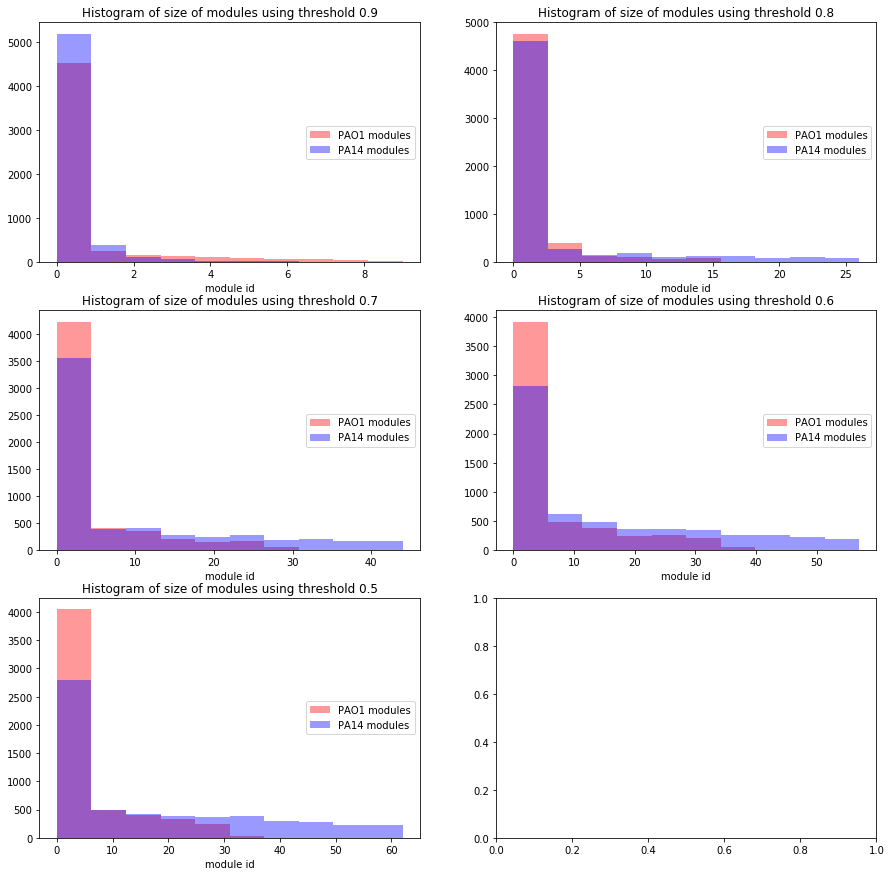

In [4]:
# Plot distribution of modules per threshold
plot_dist_modules(corr_threshold_list)

**Takeaway:**
* Looks like as we decrease our correlation threshold (i.e. connections don't need to be very strong between nodes), more modules are able to form which is what I would expect.

## Examine composition of modules

We expect that genes within the same operon or regulon will cluster together (i.e. be within the same module). To test this we will compare the distribution of the number of modules that contain genes within the same regulon vs the number of modules that contain random genes

In [5]:
# Load PAO1 regulon and operon file
pao1_regulon_filename = paths.PAO1_REGULON
pao1_operon_filename = paths.PAO1_OPERON

# Load membership for specific threshold
corr_threshold = 0.9
pao1_membership_filename = f"pao1_membership_{corr_threshold}.tsv"

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", header=0, index_col=0)

In [6]:
pao1_membership.head()

,module id
PA0001,0.0
PA0002,0.0
PA0003,0.0
PA0004,0.0
PA0005,0.0


### Format operon/regulon files

* Remove genes from operons/regulons that don't have membership information
* Make random list of genes with matched size

In [7]:
# Read file
pao1_operon = pd.read_csv(pao1_operon_filename, index_col=0, header=0)
pao1_regulon = pd.read_csv(pao1_regulon_filename, index_col=0, header=0)

print(pao1_operon.shape)
pao1_operon.head()

(3257, 2)


,Length,Genes
OperonID,,
12029,4,PA0001;PA0002;PA0003;PA0004
12030,2,PA0005;PA0006
12031,2,PA0008;PA0009
12032,3,PA0016;PA0017;PA0018
12033,2,PA0021;PA0022


In [8]:
print(pao1_regulon.shape)
pao1_regulon.head()

(17, 2)


,Lengths,Genes
Regulon,,
Anr_regulon,72,PA5475;PA1673;PA5027;PA3337;PA4348;PA4347;PA43...
PhoB_regulon,160,PA0050;PA0051;PA0082;PA0102;PA0105;PA0165;PA01...
PvdR_regulon,14,PA2386;PA2399;PA2397;PA2396;PA2425;PA2413;PA24...
PchR_regulon,12,PA4231;PA4230;PA4229;PA4228;PA4226;PA4225;PA42...
AlgU_regulon,238,PA0059;PA0060;PA0061;PA0062;PA0071;PA0134;PA01...


In [9]:
# Convert "Genes" column from str to list
pao1_operon["Genes"] = pao1_operon["Genes"].str.split(";")
pao1_regulon["Genes"] = pao1_regulon["Genes"].str.split(";")

In [10]:
# Check if genes within operon/regulon have membership information
# Only keep genes that are found in "pao1_membership"
pao1_operon["Genes_processed"] = pao1_operon["Genes"].apply(
    lambda list_genes: [
        gene_id for gene_id in list_genes if gene_id in pao1_membership.index
    ]
)
pao1_regulon["Genes_processed"] = pao1_regulon["Genes"].apply(
    lambda list_genes: [
        gene_id for gene_id in list_genes if gene_id in pao1_membership.index
    ]
)

In [11]:
# Update length based on filtered gene list ("Genes_processed" column)
pao1_operon["Length_processed"] = pao1_operon["Genes_processed"].str.len()
pao1_regulon["Length_processed"] = pao1_regulon["Genes_processed"].str.len()

In [12]:
# For each regulon/operon, select a random set of genes that are the same size at the regulon/operon
pao1_operon["Random_Genes"] = pao1_operon["Length_processed"].apply(
    lambda num_genes: pao1_membership.sample(num_genes).index.values
)
pao1_regulon["Random_Genes"] = pao1_regulon["Length_processed"].apply(
    lambda num_genes: pao1_membership.sample(num_genes).index.values
)

In [13]:
pao1_operon.head()

,Length,Genes,Genes_processed,Length_processed,Random_Genes
OperonID,,,,,
12029,4,"[PA0001, PA0002, PA0003, PA0004]","[PA0001, PA0002, PA0003, PA0004]",4,"[PA2343, PA0361, PA5405, PA0117]"
12030,2,"[PA0005, PA0006]","[PA0005, PA0006]",2,"[PA3653, PA0331]"
12031,2,"[PA0008, PA0009]","[PA0008, PA0009]",2,"[PA0840, PA0639]"
12032,3,"[PA0016, PA0017, PA0018]","[PA0016, PA0017, PA0018]",3,"[PA3674, PA4724.1, PA4235]"
12033,2,"[PA0021, PA0022]","[PA0021, PA0022]",2,"[PA1550, PA1512]"


In [14]:
pao1_regulon.head()

,Lengths,Genes,Genes_processed,Length_processed,Random_Genes
Regulon,,,,,
Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...","[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",72,"[PA0228, PA5525, PA0008, PA4976, PA1554, PA448..."
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",160,"[PA3628, PA0396, PA1654, PA1675, PA4340, PA060..."
PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...","[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",14,"[PA4875, PA4362, PA4515, PA1491, PA5218, PA446..."
PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...","[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",12,"[PA5187, PA4591, PA0973, PA2603, PA2435, PA300..."
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",228,"[PA0898, PA0415, PA2835, PA2053, PA0940, PA025..."


### Calculate the distribution

In [15]:
# For each regulon/operon get the number of modules that regulon/operon genes are found in, number of modules
# that random genes are found in
pao1_operon["Num_operon_modules"] = pao1_operon["Genes_processed"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)
pao1_operon["Num_random_modules"] = pao1_operon["Random_Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)

In [16]:
pao1_regulon["Num_regulon_modules"] = pao1_regulon["Genes_processed"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)
pao1_regulon["Num_random_modules"] = pao1_regulon["Random_Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)

In [17]:
pao1_operon.head()

,Length,Genes,Genes_processed,Length_processed,Random_Genes,Num_operon_modules,Num_random_modules
OperonID,,,,,,,
12029,4,"[PA0001, PA0002, PA0003, PA0004]","[PA0001, PA0002, PA0003, PA0004]",4,"[PA2343, PA0361, PA5405, PA0117]",1,3
12030,2,"[PA0005, PA0006]","[PA0005, PA0006]",2,"[PA3653, PA0331]",1,1
12031,2,"[PA0008, PA0009]","[PA0008, PA0009]",2,"[PA0840, PA0639]",1,2
12032,3,"[PA0016, PA0017, PA0018]","[PA0016, PA0017, PA0018]",3,"[PA3674, PA4724.1, PA4235]",1,1
12033,2,"[PA0021, PA0022]","[PA0021, PA0022]",2,"[PA1550, PA1512]",2,1


In [18]:
pao1_regulon.head()

,Lengths,Genes,Genes_processed,Length_processed,Random_Genes,Num_regulon_modules,Num_random_modules
Regulon,,,,,,,
Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...","[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",72,"[PA0228, PA5525, PA0008, PA4976, PA1554, PA448...",2,9
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",160,"[PA3628, PA0396, PA1654, PA1675, PA4340, PA060...",8,8
PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...","[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",14,"[PA4875, PA4362, PA4515, PA1491, PA5218, PA446...",1,4
PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...","[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",12,"[PA5187, PA4591, PA0973, PA2603, PA2435, PA300...",1,2
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",228,"[PA0898, PA0415, PA2835, PA2053, PA0940, PA025...",7,10


In [19]:
# Format df for plotting using displot
pao1_operon_toplot = pd.melt(
    pao1_operon, value_vars=["Num_operon_modules", "Num_random_modules"]
)
pao1_regulon_toplot = pd.melt(
    pao1_regulon, value_vars=["Num_regulon_modules", "Num_random_modules"]
)

pao1_operon_toplot.tail()

,variable,value
6509,Num_random_modules,1
6510,Num_random_modules,1
6511,Num_random_modules,1
6512,Num_random_modules,1
6513,Num_random_modules,1


In [20]:
def cumulative_distribution(
    data,
    scaled=False,
    survival=False,
    label="Cumulative",
    fill=False,
    flip=False,
    preserve_ends=0,
    **kwargs,
):
    """
    plots cumulative (or survival) step distribution
    adapted from https://github.com/MarvinT/morphs/blob/master/morphs/plot/utils.py
    """
    data = np.sort(data)
    if survival:
        data = data[::-1]
    y = np.arange(data.size + 1, dtype=float)
    if scaled:
        y /= y[-1]
    x = np.concatenate([data, data[[-1]]])
    plt.step(x, y, label=label, **kwargs)
    if fill:
        plt.fill_between(x, y, alpha=0.5, step="pre", **kwargs)

Ks_2sampResult(statistic=0.06386245010746083, pvalue=3.140402287280761e-06)

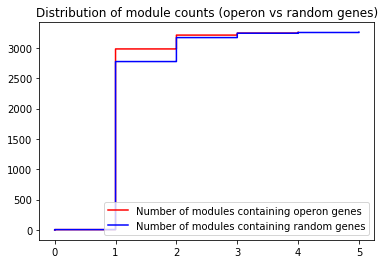

In [21]:
cumulative_distribution(
    pao1_operon["Num_operon_modules"],
    label="Number of modules containing operon genes",
    color="red",
)
cumulative_distribution(
    pao1_operon["Num_random_modules"],
    label="Number of modules containing random genes",
    color="blue",
)
_ = plt.legend()
plt.title("Distribution of module counts (operon vs random genes)")

scipy.stats.ks_2samp(
    pao1_operon["Num_operon_modules"], pao1_operon["Num_random_modules"]
)

Text(0.5, 1.0, 'Distribution of module counts (operon vs random genes)')

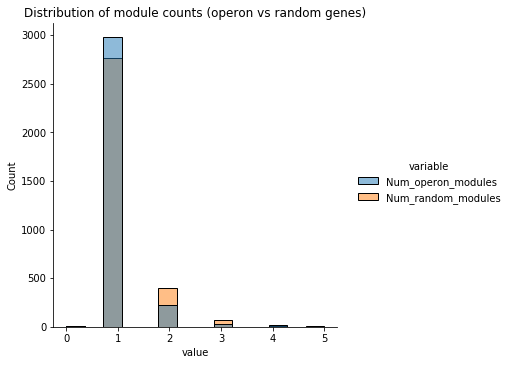

In [22]:
fig = sns.displot(
    pao1_operon_toplot,
    x="value",
    hue="variable",
)
plt.title("Distribution of module counts (operon vs random genes)")

Ks_2sampResult(statistic=0.47058823529411764, pvalue=0.030503048575092003)

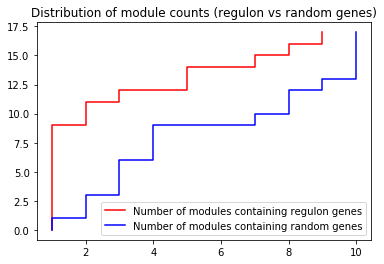

In [23]:
cumulative_distribution(
    pao1_regulon["Num_regulon_modules"],
    label="Number of modules containing regulon genes",
    color="red",
)
cumulative_distribution(
    pao1_regulon["Num_random_modules"],
    label="Number of modules containing random genes",
    color="blue",
)
_ = plt.legend()
plt.title("Distribution of module counts (regulon vs random genes)")

scipy.stats.ks_2samp(
    pao1_regulon["Num_regulon_modules"], pao1_regulon["Num_random_modules"]
)

Text(0.5, 1.0, 'Distribution of module counts (regulon vs random genes)')

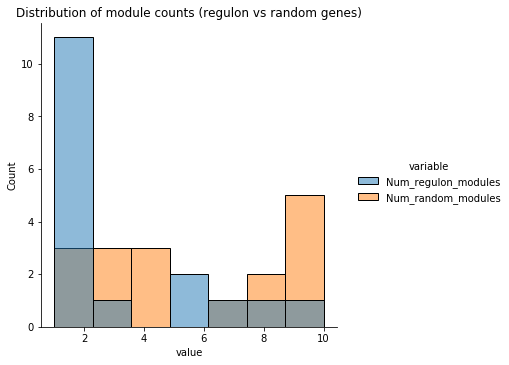

In [24]:
fig = sns.displot(
    pao1_regulon_toplot,
    x="value",
    hue="variable",
)
plt.title("Distribution of module counts (regulon vs random genes)")

**Takeaway:**
* The axis cumulative distribution plots are:
    * x: number of modules that operons/regulons/random genes are contained in
    * y: count
* These distribution plots are summing counts as you move from left to right, so a shift in the curves corresponds to a shift in the distribution (i.e. a curve shifted to the right means that the distribution is shifted to the right)

* We can perform [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) to compare the distribution of module counts for genes in regulons/operons versus random genes. The KS test will quantify the difference in the cumulative distribution curves.
* Based on the KS test, there is a significant difference between the two distributions as we would expect. Though there is a very large significance for the operons due to the large sample size. There are~3K operons as opposed to the 17 regulons, which has a very modestly significant p-value. This difference is fairly consistent across thresholds, though as we decrease the threshold used to create the network, the significance for the operons increases slightly but the significance for the regulons decreases slightly.